In [1]:
from __future__ import division
from models import *
from utils.utils import *
from utils.datasets import *
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import cv2
import paho.mqtt.client as paho
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure, draw, pause
from IPython import display

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

In [2]:
#objects=[70,220,120,50] #person:70, cars:220, motorcycle:120, dogs:50
objects=[200,220,120,50] #person:70, cars:220, motorcycle:120, dogs:50

imagesp = "Images"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("output", exist_ok=True)

# Set up model
model = Darknet("config/yolov3.cfg", img_size=416).to(device)
model.load_darknet_weights("weights/yolov3.weights")
model.eval()  # Set in evaluation mode
classes = load_classes("data/coco.names")  # Extracts class labels from file

video_capture = cv2.VideoCapture(0)

KeyboardInterrupt: 

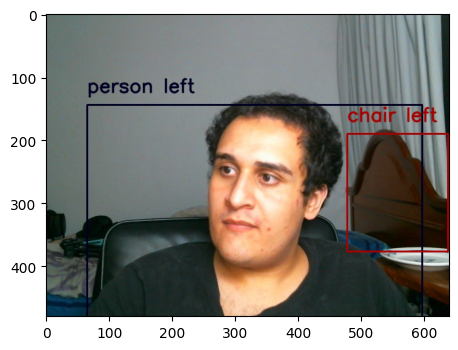

In [5]:
while 1:
    ret, frame = video_capture.read()
    cv2.imwrite('Images/test.jpg',frame) 
    distance=100000
    distancemem=100000
    labelmem=""
    labelmod=""
    pos=""
    imgs = []  # Stores image paths
    img_detections = []  # Stores detections for each image index

    dataloader = DataLoader(
        ImageFolder(imagesp, img_size=416),
        batch_size=1,
        shuffle=False,
        num_workers=0,
    )
    
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    
    for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
        # Configure input
        input_imgs = Variable(input_imgs.type(Tensor))
    
        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)
            detections = non_max_suppression(detections, 0.8, 0.4)
    
        imgs.extend(img_paths)
        img_detections.extend(detections)
        
    # Iterate through images and save plot of detections
    for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):
    
        img = np.array(Image.open(path))
        imag = cv2.imread(path)
        (H, W) = imag.shape[:2]
        
        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to original image
            detections = rescale_boxes(detections, 416, img.shape[:2])
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                if(x1>5000 or y2>5000 or y1>5000 or x2>5000):
                    # False Detection Low-Pass Filter
                    break
                #print((x1+((x2-x1)/2)).item()-100)

                add=" "
                
                if((W/2)<(x1+((x2-x1)/2)).item()):
                    pos="1"
                    add=add+"left "
                else:
                    pos="0"
                    add=add+"right "
                i=0
                if(classes[int(cls_pred)]=="motorbike"):
                    i=i+1
                    check=objects[2]
                    labelmem="m"+pos
                elif(classes[int(cls_pred)]=="dog"):
                    i=i+2
                    check=objects[3]
                    labelmem="d"+pos
                elif(classes[int(cls_pred)]=="person"):
                    i=i+3
                    check=objects[0]
                    labelmem="p"+pos
                elif(classes[int(cls_pred)]=="car"):
                    i=i+4
                    check=objects[1]
                    labelmem="c"+pos
                else:
                    i=i+5
                    check = 1000000
                COLORS1 = int(254 * math.sin(i))
                COLORS2 = int(254 * math.sin(i+1))
                COLORS3 = int(254 * math.sin(i+2))
                color= (COLORS1,COLORS2,COLORS3)
                distance=(check*16)/(19*(x2.item()/W))
                if(distance<distancemem):
                    # Checking if the object is less than 3 meters from our car.
                    if(300>distance):
                        distancemem=distance
                        labelmod = labelmem
                        add=add+"close "
                # Create a Rectangle patch
                cv2.rectangle(imag, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
                cv2.putText(imag, classes[int(cls_pred)]+add,(int(x1), int(y1)-20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    img = imag
    scale_percent = 100 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite('Images/display.jpg',resized) 
    img=mpimg.imread('Images/display.jpg')
    plt.imshow(img)
    display.clear_output(wait=True)
    display.display(plt.gcf())